In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import os, sys
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules.preprocessing import *
from modules.io import *
from modules.learning import *
from modules.statistics import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import normalize
import seaborn
import pickle
from tqdm.notebook import tqdm
plt.style.use('ggplot')

# Test the performance of the yaw misalignment regression method

# Load Data

In [2]:
dataset_file = '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet'
df = load_df(dataset_file)
df = df.dropna(axis=1, how='all')
df.columns = df.columns.str.replace('cor. ', '', regex=False)
cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
        'nacelle direction', 'wind direction']
df = df[cols]

# Resample and apply filters

In [3]:
granularity = '1min'
# Resample with 60second granularity
df=change_granularity(df,granularity=granularity)

# calculate dynamic yaw misalignment and take a 60-min rolling mean
df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
df["theta_d"][df["theta_d"] > +180] -= 360
df["theta_d"][df["theta_d"] < -180] += 360
df["theta_d"] = df["theta_d"].rolling(60).mean()
df = df.dropna()

df_initial = df.copy()

# Perform IQR outlier removal
df = outliers_IQR(df)

# drop values of wind speed under 5m/s
df=filter_col(df, 0, less_than=5, bigger_than=11)

# drop values with pitch angle higher than 2 degrees or lower than -2 degrees
df=filter_col(df, 1, less_than=-2, bigger_than=2)

# drop values of rotor speed under 8rpm
df=filter_col(df, 2, less_than=8, bigger_than=15)

# drop values of power near the power_limit and near or below zero

power_limit = 2050
df=filter_col(df, 4, less_than=1e-4, bigger_than= 1 * power_limit)


# Keep only dates with lidar measurements
start = '2018-06-02'
end = '2019-01-11'
df = filter_dates(df, start, end)

# Remove Outliers using LoF
# df = outliers_LoF(df, n_neighbors=20).copy()

# # Uncomment for plots
# ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
# df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering, IQR, and LoF')
# plt.title(f"Data before and after filtering, IQR, and LoF")
# plt.show()

Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
Filter Complete
Filter Complete
Filter Complete
Filter Complete


# Add a column with the measured static yaw misalignment

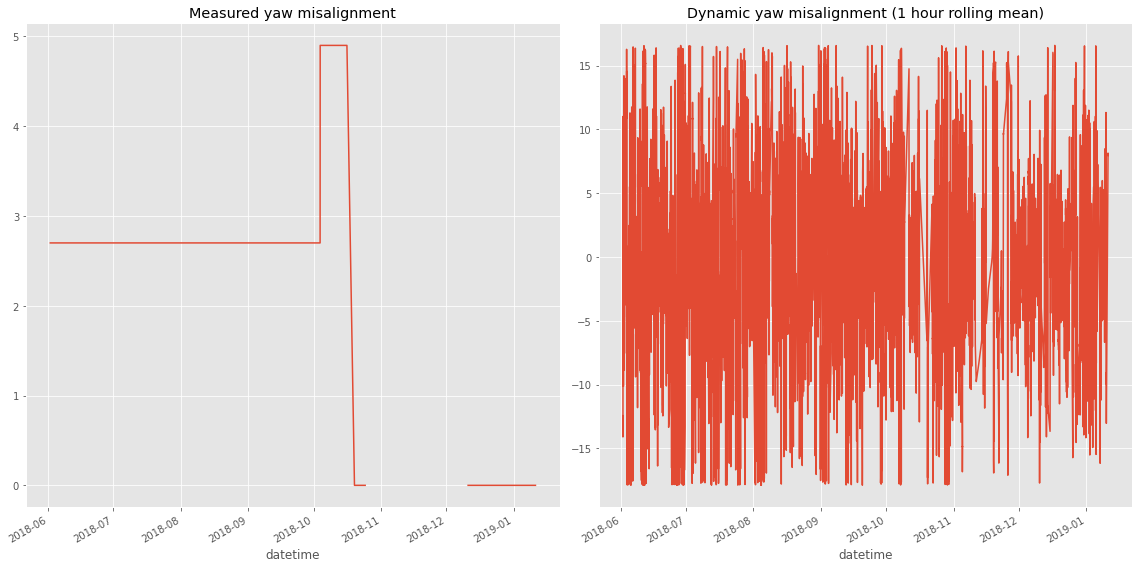

In [4]:
df_labels = pd.read_csv('/data/data2/panos/Yaw.csv')
df["y"] = np.nan
df_l = df_labels[df_labels.Turbines == dataset_file]
for start, end, static in zip(df_l.StartDate, df_l.EndDate, df_l.StaticYaw):
    df.loc[start:end, 'y'] = static
static_misalignment_values = list(df_l.StaticYaw.values)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

ax1 = df['y'].plot(ax=axs[0])
ax1.set_title(f"Measured yaw misalignment")

ax2 = df['theta_d'].plot(ax=axs[1])
ax2.set_title(f"Dynamic yaw misalignment (1 hour rolling mean)")
plt.tight_layout()
plt.show()

### Split dataset into bins based on wind speed

In [5]:
bin_size = 6
min_speed = 5
max_speed = 11
bins = np.arange(min_speed, max_speed, bin_size)
bins = np.append(bins,max_speed)
print(bins)
bin_masks = []
bin_feature = 'wind speed'
for i in range(len(bins) - 1):
    mask = (df[bin_feature]>= bins[i]) & (df[bin_feature] < bins[i + 1])
    bin_masks.append(mask)

[ 5 11]


# Estimate the yaw angle using the most fitting pre trained model label

In [6]:
# specify the file to load the trained models and scaler from
models_file = 'Models_Select_Bins.pickle' 
scaler_file = 'select_bins_scaler.pickle'

with open(models_file, 'rb') as file:
    all_models_dict = pickle.load(file)
    
with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)
    
df_scaled = df.copy().drop(columns='y') 
df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
df_scaled['y'] = df['y']
    
binned_data_dfs = []
for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
    
target_feature = 'active power'

print(static_misalignment_values)
all_evaluation_scores = {}
for theta_s in tqdm(np.unique(static_misalignment_values)):
    print(f'Working on {theta_s}')
    all_evaluation_scores[str(theta_s)] = {}
    for dataset_key, dataset_dict in all_models_dict.items():
        print(f"Dataset : {dataset_key}")
        all_evaluation_scores[str(theta_s)][dataset_key] = {}
        fit_features = dataset_dict['selected_features']
        models_dict = dataset_dict['models']
        evaluation_scores = {}
        for key, models in models_dict.items():
            
            mape_list = []
            print(f'evaluating with models trained on {key}')
            for bin_n, d in enumerate(binned_data_dfs):
                d = d[d['y'] == theta_s].copy()
                if d.shape[0] >= 100 and models[bin_n] is not None:
                    test_preds = predict(d, models[bin_n], fit_features, target_feature)
                    
                    r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                    mape_list.append(mape)
                else:
                    pass
            avg_mape = np.mean(mape_list)
            evaluation_scores[key] = avg_mape
        all_evaluation_scores[str(theta_s)][dataset_key].update(evaluation_scores.copy())
print(all_evaluation_scores)

[2.7, 2.7, 4.9, 0.0, 0.0]


  0%|          | 0/3 [00:00<?, ?it/s]

Working on 0.0
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
evaluating with models trained on -6.7
evaluating with models trained on 0.0
evaluating with models trained on 4.8
evaluating with models trained on 9.4
Dataset : 2/BEBEZE03_scada_high_frequency.parquet
evaluating with models trained on -2.2
evaluating with models trained on 0.0
evaluating with models trained on 3.4
evaluating with models trained on 7.5
Working on 2.7
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
evaluating with models trained on -6.7
evaluating with models trained on 0.0
evaluating with models trained on 4.8
evaluating with models trained on 9.4
Dataset : 2/BEBEZE03_scada_high_frequency.parquet
evaluating with models trained on -2.2
evaluating with models trained on 0.0
evaluating with models trained on 3.4
evaluating with models trained on 7.5
Working on 4.9
Dataset : 1/BEBEZE01_scada_high_frequency.parquet
evaluating with models trained on -6.7
evaluating with models trained on 0.0
evaluating with 

# Plot the results

RMSE = 1.3474269480675594
MAE = 0.7309368084583231


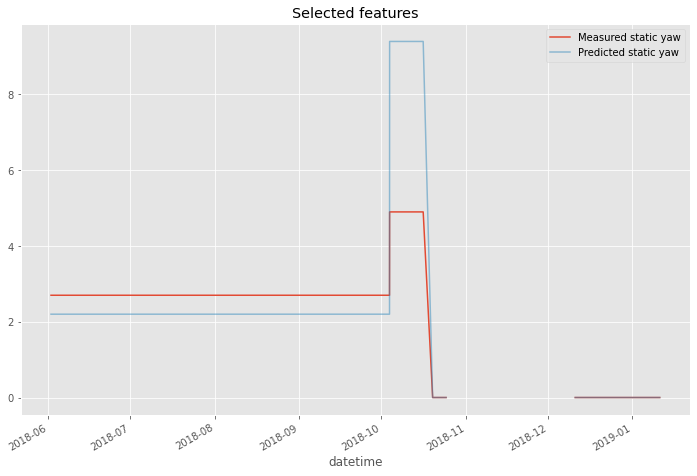

In [7]:
# Assign the label of model with the best fitting score as the predicted label
df['y_pred'] = np.nan
for th_s, dict1 in all_evaluation_scores.items(): 
    
    min_score = float("inf")
    th_s_label = ''
    for dataset_file, evaluation_scores in dict1.items(): 
        d = evaluation_scores
        
        label = min(d, key = d.get) 
        
        sc = d[label]
        
        
        if sc <= min_score:
            min_score = sc
            th_s_label = label
    df['y_pred'][df['y']==float(th_s)] = np.abs(float(th_s_label))
    
prediction = np.abs(df['y_pred'])

target = np.abs(df['y'])

# Calculate RMSE and MAE
rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

df_true_yaw = pd.DataFrame()
df_true_yaw['y'] = np.abs(df['y'])
df_true_yaw['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()

# Create box-plots

1


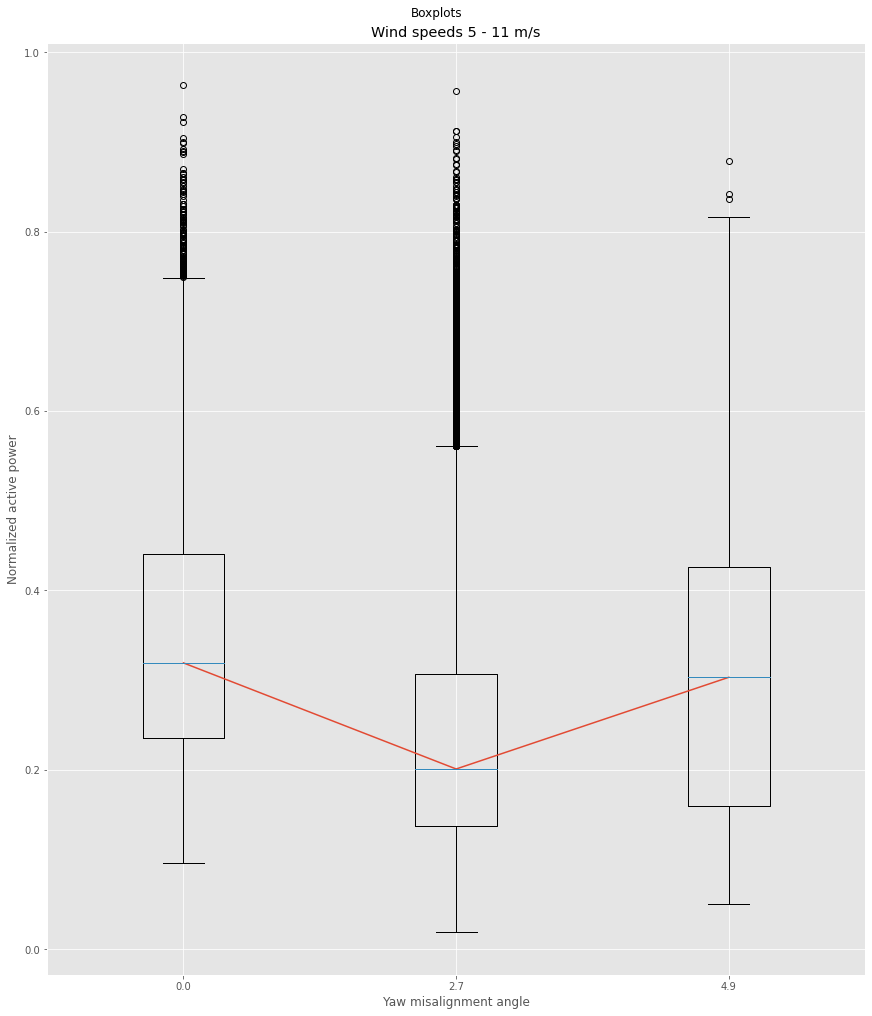

In [8]:
angles = np.sort(np.abs(np.unique(static_misalignment_values)))
bins = np.arange(min_speed, max_speed, bin_size)
bins = np.append(bins,max_speed)
print(len(binned_data_dfs))
if len(binned_data_dfs) > 1:
    fig, axes = plt.subplots(nrows=int(len(binned_data_dfs)/2), ncols=2, figsize=(12,14), constrained_layout=True)
    axes = axes.ravel()
else:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,14), constrained_layout=True)
    axes = [axes]
plt.suptitle(f'Boxplots')
for bin_n, d in enumerate(binned_data_dfs):
    #print(f"Plot for bin #{bin_n + 1}")
    bin_data = []
    means = [np.nan]
    for theta_s in angles:
        d['y'] = np.abs(d['y'])
        df_temp = d[d['y'] == theta_s].copy()
        means.append(df_temp['active power'].median())
        # print(f"Median of {theta_s} is {means[-1]}")
        bin_data.append(df_temp['active power'].values)
    ax = axes[bin_n] 
    ax.set_title(f'Wind speeds {bins[bin_n]} - {bins[bin_n + 1]} m/s')
    ax.boxplot(bin_data)
    ax.plot(means)
    locs = ax.get_xticks()
    ax.set_ylabel('Normalized active power')
    ax.set_xlabel('Yaw misalignment angle')
    ax.set_xticklabels(angles)
#plt.savefig(f'boxplots_{turbine}.jpg')
plt.show()


RMSE = 4.6358560215318105
MAE = 3.620833046471601


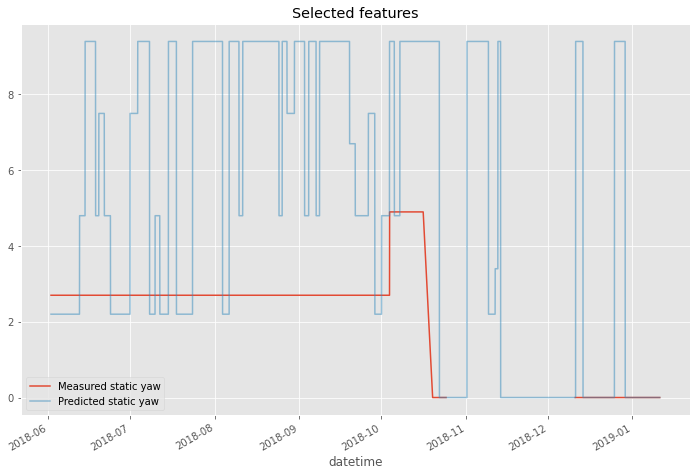

In [9]:
# specify the file to load the trained models and scaler from
models_file = 'Models_Select_Bins.pickle' 
scaler_file = 'select_bins_scaler.pickle'

with open(models_file, 'rb') as file:
    all_models_dict = pickle.load(file)
    
with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)
    
df_scaled = df.copy().drop(columns=['y', 'y_pred']) 
df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
df_scaled['y'] = df['y']
d = 1
window = d * 1440
df['y_pred'] = np.nan

for w in range(0, len(df), window):
    binned_data_dfs = []
    for b in bin_masks:
        df_temp = df_scaled[w:w+window][b[w:w+window]]
        binned_data_dfs.append(df_temp.copy())
        # binned_data_dfs.append(df_temp.copy())

    target_feature = 'active power'

    all_evaluation_scores = {}
    for dataset_key, dataset_dict in all_models_dict.items():
        all_evaluation_scores[dataset_key] = {}
        fit_features = dataset_dict['selected_features']
        models_dict = dataset_dict['models']
        evaluation_scores = {}
        for key, models in models_dict.items():
            mape_list = []
            for bin_n, d in enumerate(binned_data_dfs):
                if d.shape[0] >= 100 and models[bin_n] is not None:
                    test_preds = predict(d, models[bin_n], fit_features, target_feature)
                    r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                    mape_list.append(mape)
                else:
                    pass
            avg_mape = np.mean(mape_list)
            evaluation_scores[key] = avg_mape
        all_evaluation_scores[dataset_key].update(evaluation_scores.copy())

    # Plot the results

    # Assign the label of model with the best fitting score as the predicted label
    # df = df[:window]
    min_score = float("inf")
    th_s_label = ''
    for dataset, dict1 in all_evaluation_scores.items(): 
        for th_s, evaluation_score in dict1.items(): 
            sc = evaluation_score
            if sc <= min_score:
                min_score = sc
                th_s_label = np.abs(float(th_s))

    df['y_pred'].iloc[w:w+window] = th_s_label

prediction = np.abs(df['y_pred'])

target = np.abs(df['y'])

# Calculate RMSE and MAE
rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

df_true_yaw = pd.DataFrame()
df_true_yaw['y'] = np.abs(df['y'])
df_true_yaw['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()

RMSE = 3.767262028521732
MAE = 2.541454634865995


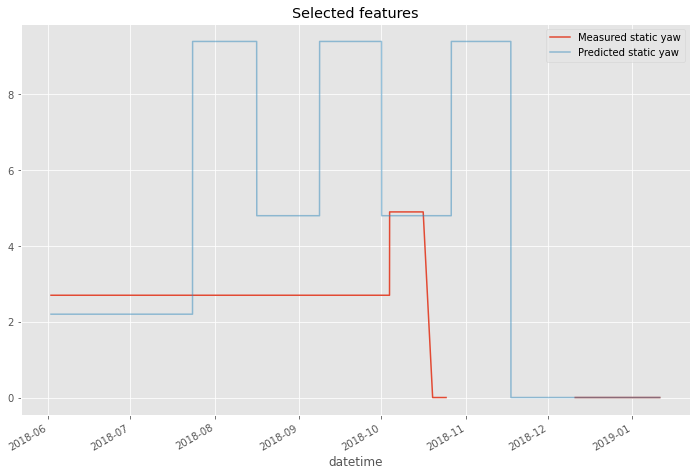

In [10]:
# specify the file to load the trained models and scaler from
models_file = 'Models_Select_Bins.pickle' 
scaler_file = 'select_bins_scaler.pickle'

with open(models_file, 'rb') as file:
    all_models_dict = pickle.load(file)
    
with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)
    
df_scaled = df.copy().drop(columns=['y', 'y_pred']) 
df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
df_scaled['y'] = df['y']
d = 10
window = d * 1440
df['y_pred'] = np.nan

for w in range(0, len(df), window):
    binned_data_dfs = []
    for b in bin_masks:
        df_temp = df_scaled[w:w+window][b[w:w+window]]
        binned_data_dfs.append(df_temp.copy())
        # binned_data_dfs.append(df_temp.copy())

    target_feature = 'active power'

    all_evaluation_scores = {}
    for dataset_key, dataset_dict in all_models_dict.items():
        all_evaluation_scores[dataset_key] = {}
        fit_features = dataset_dict['selected_features']
        models_dict = dataset_dict['models']
        evaluation_scores = {}
        for key, models in models_dict.items():
            mape_list = []
            for bin_n, d in enumerate(binned_data_dfs):
                if d.shape[0] >= 100 and models[bin_n] is not None:
                    test_preds = predict(d, models[bin_n], fit_features, target_feature)
                    r_sq, mae, me, mape, mpe = score(d[target_feature].values, test_preds)
                    mape_list.append(mape)
                else:
                    pass
            avg_mape = np.mean(mape_list)
            evaluation_scores[key] = avg_mape
        all_evaluation_scores[dataset_key].update(evaluation_scores.copy())

    # Plot the results

    # Assign the label of model with the best fitting score as the predicted label
    # df = df[:window]
    min_score = float("inf")
    th_s_label = ''
    for dataset, dict1 in all_evaluation_scores.items(): 
        for th_s, evaluation_score in dict1.items(): 
            sc = evaluation_score
            if sc <= min_score:
                min_score = sc
                th_s_label = np.abs(float(th_s))

    df['y_pred'].iloc[w:w+window] = th_s_label

prediction = np.abs(df['y_pred'])

target = np.abs(df['y'])

# Calculate RMSE and MAE
rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
m = (prediction.isna())
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")

df_true_yaw = pd.DataFrame()
df_true_yaw['y'] = np.abs(df['y'])
df_true_yaw['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Selected features')
plt.legend()
plt.show()